In [1]:
# dependencies import
from common_dependencies import *
from typing import NamedTuple
import model_versions as mv
import logging
logger = logging.getLogger(f'main.model_train')
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(290)
DataCrop = NamedTuple("DataCrop", [('left', int), ('top', int), ('width', int), ('height', int)])
DatasetPartDescription = NamedTuple("DatasetPartDescription", [('run_name', str), ('data_crop', DataCrop), ('crop_step', int)])

2024-04-09 10:26:42.839362: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: FFT
2024-04-09 10:26:42.877779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 10:26:43.286323: E external/local_xla/xla/stream_executor/plugin_registry.cc:91] Invalid plugin kind specified: DNN


In [2]:
# train params that can be easily changed
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

CROP_SIZE = 16
XSHIFT = 200
#CROP_STEP = 4

MAX_VAL = 1000

train_dataset_desc = (DatasetPartDescription('run_1', DataCrop(100,0,110,MAX_VAL), 8),)

val_dataset = (DatasetPartDescription('run_1', DataCrop(210,0,100,MAX_VAL), 8),)

In [3]:
def get_dataset_gen(path_to_data_tuple: tuple(),
                x_shift: int,
                data_part: DataCrop,
                crop_size: int, 
                crop_step: int):
    logger.debug("start")
    
    x_df, y_df = dw.get_x_and_y_data(*path_to_data_tuple)
    x_df = dw.roll_df(x_df, x_shift, 1)
    y_df = dw.roll_df(y_df, x_shift, 1)

    x_df = x_df.iloc[data_part.top:data_part.top+data_part.height, data_part.left:data_part.left+data_part.width]
    y_df = y_df.iloc[data_part.top:data_part.top+data_part.height, data_part.left:data_part.left+data_part.width]
    
    x_df = dw.match_df_for_crops_dividing(x_df, crop_size, crop_step)
    y_df = dw.match_df_for_crops_dividing(y_df, crop_size, crop_step)

    x_arr = dw.df_to_numpy(x_df)
    y_arr = y_df.to_numpy()
    
    x_arr_time = dw.standardize_data(x_arr[:,:,:32])
    x_arr_amp = dw.standardize_data(x_arr[:,:,32:])
    y_arr = np.expand_dims(dw.standardize_data(y_arr), axis=2)
    
    x_time_crops_gen = (np.expand_dims(np.rollaxis(crop, 2, 0), axis=3) for crop in dw.get_augmented_crop_generator(x_arr_time, crop_size, crop_step))
    x_amp_crops_gen = (np.expand_dims(np.rollaxis(crop, 2, 0), axis=3) for crop in dw.get_augmented_crop_generator(x_arr_amp, crop_size, crop_step))
    y_bool_crops_gen = dw.get_augmented_crop_generator(y_arr, crop_size, crop_step)
    
    y_binary_gen = (1 if np.sum(crop > 0) else 0 for crop in dw.get_augmented_crop_generator(y_arr, crop_size, crop_step))
    y_depth_gen = (np.max(crop) for crop in dw.get_augmented_crop_generator(y_arr, crop_size, crop_step))

    logger.debug("end")
    return x_time_crops_gen, x_amp_crops_gen, y_bool_crops_gen, y_binary_gen, y_depth_gen

In [4]:
(train_x_time, 
 train_x_amp, 
 train_y_mask,
 train_y_binary,
 train_y_depth) = [np.stack(list(itertools.chain(*part))) for part in 
                           np.stack([get_dataset_gen(PATH_TO_DATA[desc_part.run_name], XSHIFT, desc_part.data_crop, CROP_SIZE, desc_part.crop_step) 
                                     for desc_part in train_dataset_desc], axis=1)]

(val_x_time, 
 val_x_amp,
 val_y_mask,
 val_y_binary,
 val_y_depth) = [np.stack(list(itertools.chain(*part))) for part in 
                           np.stack([get_dataset_gen(PATH_TO_DATA[desc_part.run_name], XSHIFT, desc_part.data_crop, CROP_SIZE, desc_part.crop_step) 
                                     for desc_part in val_dataset], axis=1)]

print(f'{train_x_time.shape=}, max={np.max(train_x_time)}, min={np.min(train_x_time)}')
print(f'{train_x_amp.shape=}, max={np.max(train_x_amp)}, min={np.min(train_x_amp)}')
print(f'{train_y_mask.shape=}, max={np.max(train_y_mask)}, min={np.min(train_y_mask)}')
print(f'{train_y_binary.shape=}, max={np.max(train_y_binary)}, min={np.min(train_y_binary)}')
print(f'{train_y_depth.shape=}, max={np.max(train_y_depth)}, min={np.min(train_y_depth)}')
print()
print(f'{val_x_time.shape=}, max={np.max(val_x_time)}, min={np.min(val_x_time)}')
print(f'{val_x_amp.shape=}, max={np.max(val_x_amp)}, min={np.min(val_x_amp)}')
print(f'{val_y_mask.shape=}, max={np.max(val_y_mask)}, min={np.min(val_y_mask)}')
print(f'{val_y_binary.shape=}, max={np.max(val_y_binary)}, min={np.min(val_y_binary)}')
print(f'{val_y_depth.shape=}, max={np.max(val_y_depth)}, min={np.min(val_y_depth)}')

train_x_time.shape=(2912, 32, 16, 16, 1), max=1.0, min=0.0
train_x_amp.shape=(2912, 32, 16, 16, 1), max=1.0, min=-0.983743967487935
train_y_mask.shape=(2912, 16, 16, 1), max=1.0, min=0.0
train_y_binary.shape=(2912,), max=1, min=0
train_y_depth.shape=(2912,), max=1.0, min=0.0

val_x_time.shape=(2688, 32, 16, 16, 1), max=1.0, min=0.0
val_x_amp.shape=(2688, 32, 16, 16, 1), max=1.0, min=-0.9834672385647066
val_y_mask.shape=(2688, 16, 16, 1), max=1.0, min=0.0
val_y_binary.shape=(2688,), max=1, min=0
val_y_depth.shape=(2688,), max=1.0, min=0.0


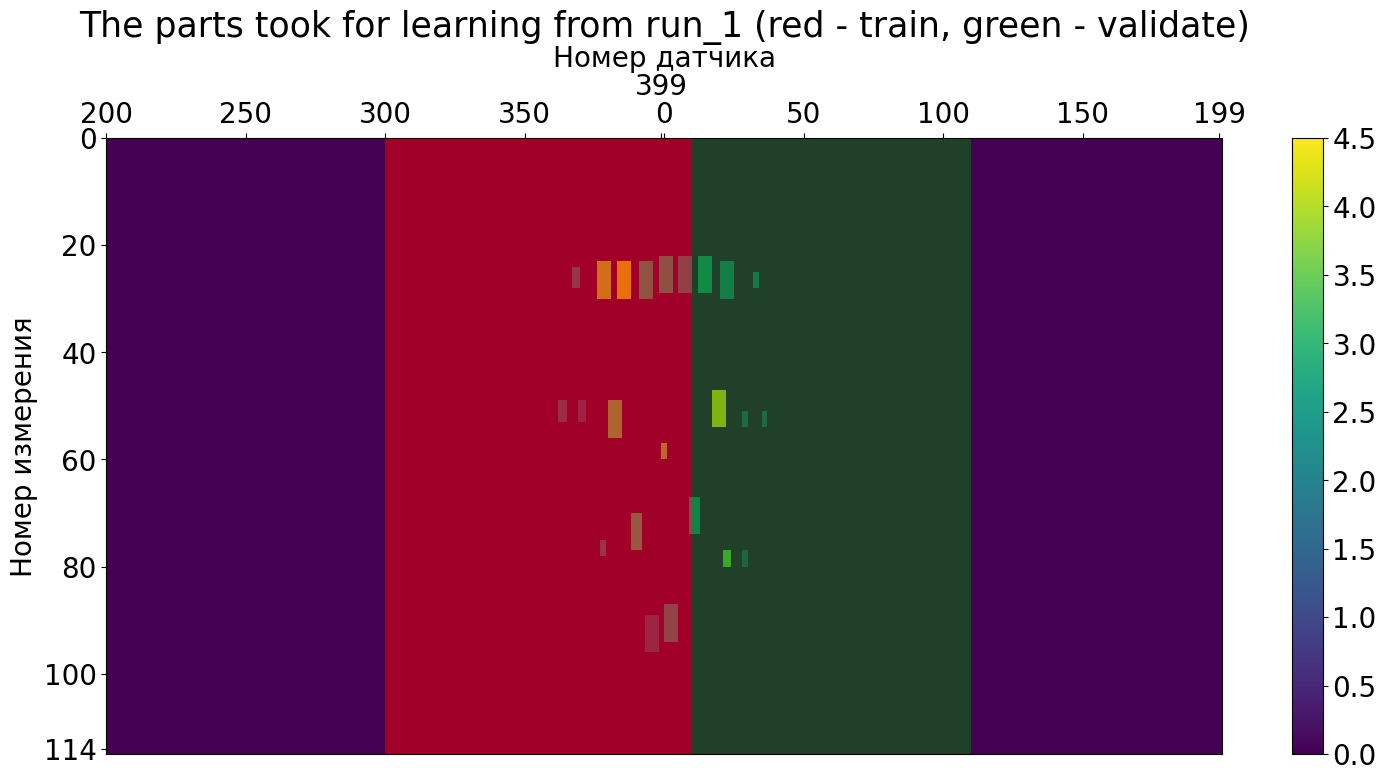

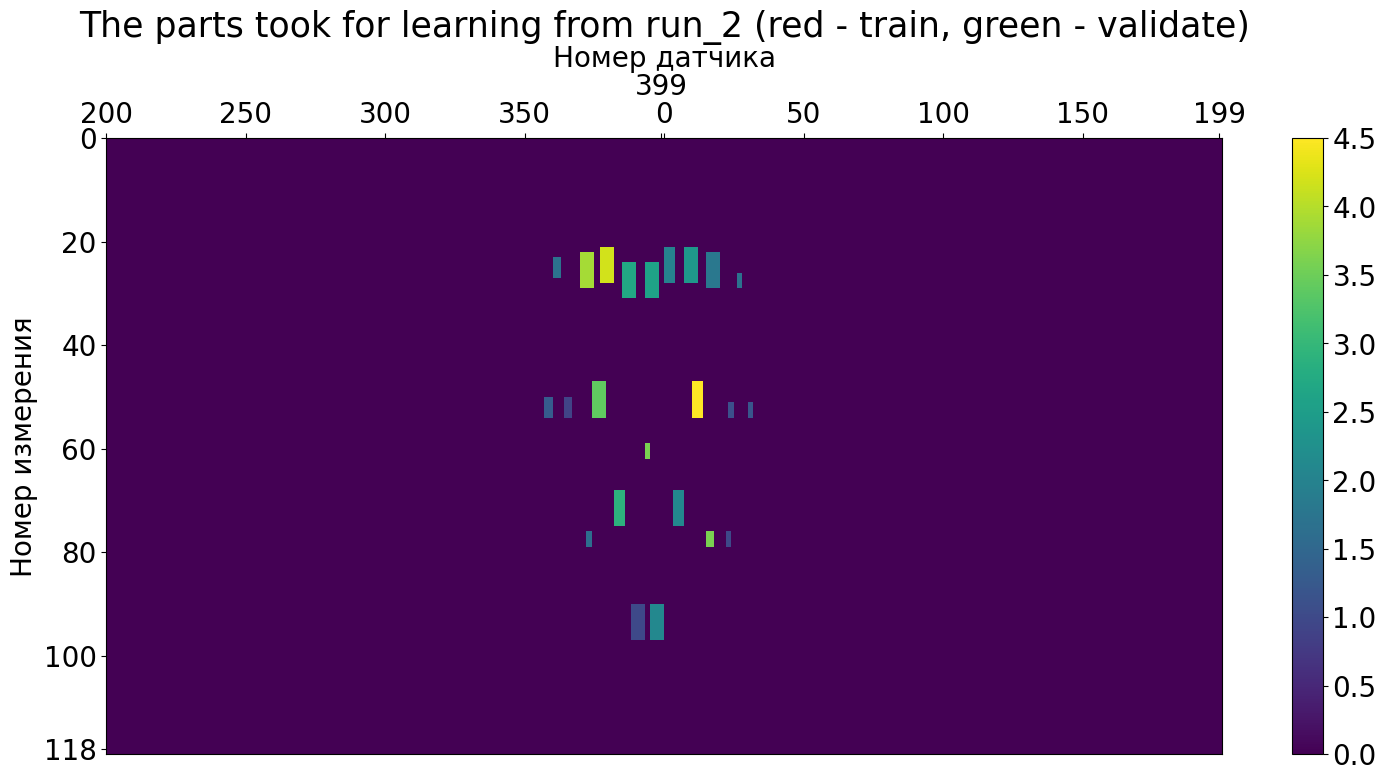

In [5]:
# show parts took for learning
x_df1, y_df1 = dw.get_x_and_y_data(*PATH_TO_DATA['run_1'])
x_df2, y_df2 = dw.get_x_and_y_data(*PATH_TO_DATA['run_2'])
x_df1 = x_df2 = None

y_df1 = dw.roll_df(y_df1, XSHIFT, 1)
y_df2 = dw.roll_df(y_df2, XSHIFT, 1)

train_run_1_rects = []
train_run_2_rects = []
val_run_1_rects = []
val_run_2_rects = []

for data_desc in train_dataset_desc:
    if data_desc.run_name == 'run_1':
        train_run_1_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                           data_desc.data_crop.width, data_desc.data_crop.height, facecolor='red', alpha=0.5))
    else:
        train_run_2_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                           data_desc.data_crop.width, data_desc.data_crop.height, facecolor='red', alpha=0.5))

for data_desc in val_dataset:
    if data_desc.run_name == 'run_1':
        val_run_1_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='green', alpha=0.5))
    else:
        val_run_2_rects.append(Rectangle((data_desc.data_crop.left, data_desc.data_crop.top), 
                                         data_desc.data_crop.width, data_desc.data_crop.height, facecolor='green', alpha=0.5))


dw.draw_defects_map_with_rectangles_owerlap(y_df1, train_run_1_rects+val_run_1_rects, title = f'The parts took for learning from run_1 (red - train, green - validate)')
dw.draw_defects_map_with_rectangles_owerlap(y_df2, train_run_2_rects+val_run_2_rects, title = f'The parts took for learning from run_2 (red - train, green - validate)')

In [6]:
'''augment_data = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomTranslation(0.2,0.2,fill_mode="reflect"),
  layers.RandomZoom(0.2,0.2,fill_mode="reflect"),
  #layers.RandomCrop(32, 32)
])'''

'augment_data = tf.keras.Sequential([\n  layers.RandomFlip("horizontal_and_vertical"),\n  layers.RandomRotation(0.2),\n  layers.RandomTranslation(0.2,0.2,fill_mode="reflect"),\n  layers.RandomZoom(0.2,0.2,fill_mode="reflect"),\n  #layers.RandomCrop(32, 32)\n])'

In [7]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.00008 #0.0000002 # шаг сходимости back propogation
#CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_funcs = keras.losses.BinaryCrossentropy() #BinaryCrossentropy() 
CMP_metrics = ([keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
               keras.metrics.MeanSquaredError(name='MSE'),
               #keras.metrics.BinaryCrossentropy(name='BinaryCrossentropy'),
               keras.metrics.TruePositives(name='TruePositives'),
               keras.metrics.FalsePositives(name='FalsePositives'),
               keras.metrics.TrueNegatives(name='TrueNegatives'),
               keras.metrics.FalseNegatives(name='FalseNegatives'),     
               keras.metrics.Precision(name='Precision'),
               keras.metrics.Recall(name='Recall'),
               keras.metrics.AUC(name='AUC')]
               ,[keras.metrics.MeanSquaredError(name='MSE')],
                [keras.metrics.MeanSquaredError(name='MSE')],
                [keras.metrics.MeanSquaredError(name='MSE')],
                [keras.metrics.MeanSquaredError(name='MSE')],
                [keras.metrics.MeanSquaredError(name='MSE')],
                [keras.metrics.MeanSquaredError(name='MSE')],)
#///////////////////////////////// для колбэков

# для Early_stopping
ES_patience = 3 # кол-во эпох без улучшений
ES_min_delta = 0.0001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'output_def_bool_Precision' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
ES_mode='max'

   # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
RLPOP_factor = 0.3 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 1 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 2 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 # размерpython concat lists bach при обучении/тестировании1
#FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 5 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

2024-04-09 10:26:56.788691: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 10:26:56.810809: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 10:26:56.810866: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 10:26:56.812431: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:924] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-09 10:26:56.812503: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [8]:
#model = mv.get_model_v10(CROP_SIZE)
DROP = 0.4

def bnorm(layer, drop_percent):
    return Dropout(drop_percent)(BatchNormalization()(layer))
    #return Dropout(drop_percent)(layer)
    #return BatchNormalization()(layer)

def output(layer, out_name):
    d = Dense(128, activation='linear')(Flatten()(layer))
    d = Dense(32, activation='linear')(d)
    d = Dense(8, activation='linear')(d)
    return Dense(1, activation='sigmoid', name=out_name)(d)

# 1 подсеть //////////////////////////////////////////////////
input_time = Input((32,16,16,1), name = 'input_time')
conv2dlstm_1_1 = layers.ConvLSTM2D(32,(3,3), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_1')(input_time)
conv2dlstm_1_2 = layers.ConvLSTM2D(32,(3,3), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_2')(conv2dlstm_1_1)
conv2dlstm_1_3 = layers.ConvLSTM2D(32,(3,3), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_3')(conv2dlstm_1_2)
pool_1_1 = layers.MaxPooling3D((1,2,2), strides=(1,2,2), name='pool_1_1')(conv2dlstm_1_3)

out_1_1 = output(bnorm(pool_1_1, DROP),'out_1_1')

conv2dlstm_1_4 = layers.ConvLSTM2D(64,(3,3), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_4')(pool_1_1)
conv2dlstm_1_5 = layers.ConvLSTM2D(64,(3,3), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_5')(conv2dlstm_1_4)
conv2dlstm_1_6 = layers.ConvLSTM2D(64,(3,3), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_6')(conv2dlstm_1_5)
pool_1_2 = layers.MaxPooling3D((1,2,2), strides=(1,2,2), name='pool_1_2')(conv2dlstm_1_6)

out_1_2 = output(bnorm(pool_1_2, DROP),'out_1_2')

conv2dlstm_1_7 = layers.ConvLSTM2D(128,(2,2), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_7')(pool_1_2)
conv2dlstm_1_8 = layers.ConvLSTM2D(128,(2,2), padding='same', return_sequences=True, activation='relu', name='conv2dlstm_1_8')(conv2dlstm_1_7)
conv2dlstm_1_9 = layers.ConvLSTM2D(128,(2,2), padding='same', return_sequences=False, activation='relu', name='conv2dlstm_1_9')(conv2dlstm_1_8)
pool_1_3 = layers.MaxPooling2D((2,2), strides=2, name='pool_1_3')(conv2dlstm_1_9)

out_1_3 = output(bnorm(pool_1_3, DROP),'out_1_3')

# 2 подсеть //////////////////////////////////////////////////
input_amp = Input((32,16,16,1), name = 'input_amp')
conv2dlstm_2_1 = layers.ConvLSTM2D(32,(3,3), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_1')(input_amp)
conv2dlstm_2_2 = layers.ConvLSTM2D(32,(3,3), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_2')(conv2dlstm_2_1)
conv2dlstm_2_3 = layers.ConvLSTM2D(32,(3,3), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_3')(conv2dlstm_2_2)
pool_2_1 = layers.MaxPooling3D((1,2,2), strides=(1,2,2), name='pool_2_1')(conv2dlstm_2_3)

out_2_1 = output(bnorm(pool_2_1, DROP),'out_2_1')

conv2dlstm_2_4 = layers.ConvLSTM2D(64,(3,3), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_4')(pool_2_1)
conv2dlstm_2_5 = layers.ConvLSTM2D(64,(3,3), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_5')(conv2dlstm_2_4)
conv2dlstm_2_6 = layers.ConvLSTM2D(64,(3,3), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_6')(conv2dlstm_2_5)
pool_2_2 = layers.MaxPooling3D((1,2,2), strides=(1,2,2), name='pool_2_2')(conv2dlstm_2_6)

out_2_2 = output(bnorm(pool_2_2, DROP),'out_2_2')

conv2dlstm_2_7 = layers.ConvLSTM2D(128,(2,2), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_7')(pool_2_2)
conv2dlstm_2_8 = layers.ConvLSTM2D(128,(2,2), padding='same', return_sequences=True, activation='linear', name='conv2dlstm_2_8')(conv2dlstm_2_7)
conv2dlstm_2_9 = layers.ConvLSTM2D(128,(2,2), padding='same', return_sequences=False, activation='linear', name='conv2dlstm_2_9')(conv2dlstm_2_8)
pool_2_3 = layers.MaxPooling2D((2,2), strides=2, name='pool_2_3')(conv2dlstm_2_9)

out_2_3 = output(bnorm(pool_2_3, DROP),'out_2_3')

# общая сверточная часть
conv2d_3_1 = Conv2D(256, (3,3), activation='linear', name='conv2d_3_1', padding='same')(concatenate([pool_1_3, pool_2_3], axis=3, name='conc_3_1'))
conv2d_3_2 = Conv2D(256, (3,3), activation='linear', name='conv2d_3_2', padding='same')(conv2d_3_1)
conv2d_3_3 = Conv2D(256, (3,3), activation='linear', name='conv2d_3_3', padding='same')(conv2d_3_2)
pool_3_1 = MaxPooling2D((2,2), strides=2, name='pool_3_1')(conv2d_3_2)

# выходная подсеть по наличию дефекта //////////////////////////////////////////////////
d_4_1 = Dense(128, activation='linear', name='d_4_1')(bnorm(Flatten(name='flat_3_1')(pool_3_1),DROP))
d_4_2 = Dense(32, activation='linear', name='d_4_2')(d_4_1)
d_4_3 = Dense(8, activation='linear', name='d_4_3')(d_4_2)
output_def_bool = Dense(1, activation='sigmoid', name='output_def_bool')(d_4_3)
    
model = keras.Model([input_time, input_amp], [output_def_bool,out_1_1,out_1_2,out_1_3,out_2_1,out_2_2,out_2_3], name='model')

model.compile(optimizer=CMP_solver, loss=CMP_loss_funcs, metrics=CMP_metrics)

print(model.summary())

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_time          │ (None, 32, 16,    │          0 │ -                 │
│ (InputLayer)        │ 16, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_amp           │ (None, 32, 16,    │          0 │ -                 │
│ (InputLayer)        │ 16, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_1_1      │ (None, 32, 16,    │     38,144 │ input_time[0][0]  │
│ (ConvLSTM2D)        │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_2_1      │ (None, 32, 16,    │     38,144 │ input_amp[0][0]   │
│ (ConvLSTM2D)        │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_1_2      │ (None, 32, 16,    │     73,856 │ conv2dlstm_1_1[0… │
│ (ConvLSTM2D)        │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_2_2      │ (None, 32, 16,    │     73,856 │ conv2dlstm_2_1[0… │
│ (ConvLSTM2D)        │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_1_3      │ (None, 32, 16,    │     73,856 │ conv2dlstm_1_2[0… │
│ (ConvLSTM2D)        │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_2_3      │ (None, 32, 16,    │     73,856 │ conv2dlstm_2_2[0… │
│ (ConvLSTM2D)        │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1_1            │ (None, 32, 8, 8,  │          0 │ conv2dlstm_1_3[0… │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2_1            │ (None, 32, 8, 8,  │          0 │ conv2dlstm_2_3[0… │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_1_4      │ (None, 32, 8, 8,  │    221,440 │ pool_1_1[0][0]    │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_2_4      │ (None, 32, 8, 8,  │    221,440 │ pool_2_1[0][0]    │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_1_5      │ (None, 32, 8, 8,  │    295,168 │ conv2dlstm_1_4[0… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_2_5      │ (None, 32, 8, 8,  │    295,168 │ conv2dlstm_2_4[0… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_1_6      │ (None, 32, 8, 8,  │    295,168 │ conv2dlstm_1_5[0… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2dlstm_2_6      │ (None, 32, 8, 8,  │    295,168 │ conv2dlstm_2_5[0… │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1_2            │ (None, 32, 4, 4,  │          0 │ conv2dlstm_1_6[0

 Total params: 31,426,263 (119.88 MB)

 Trainable params: 31,424,855 (119.88 MB)

 Non-trainable params: 1,408 (5.50 KB)

None


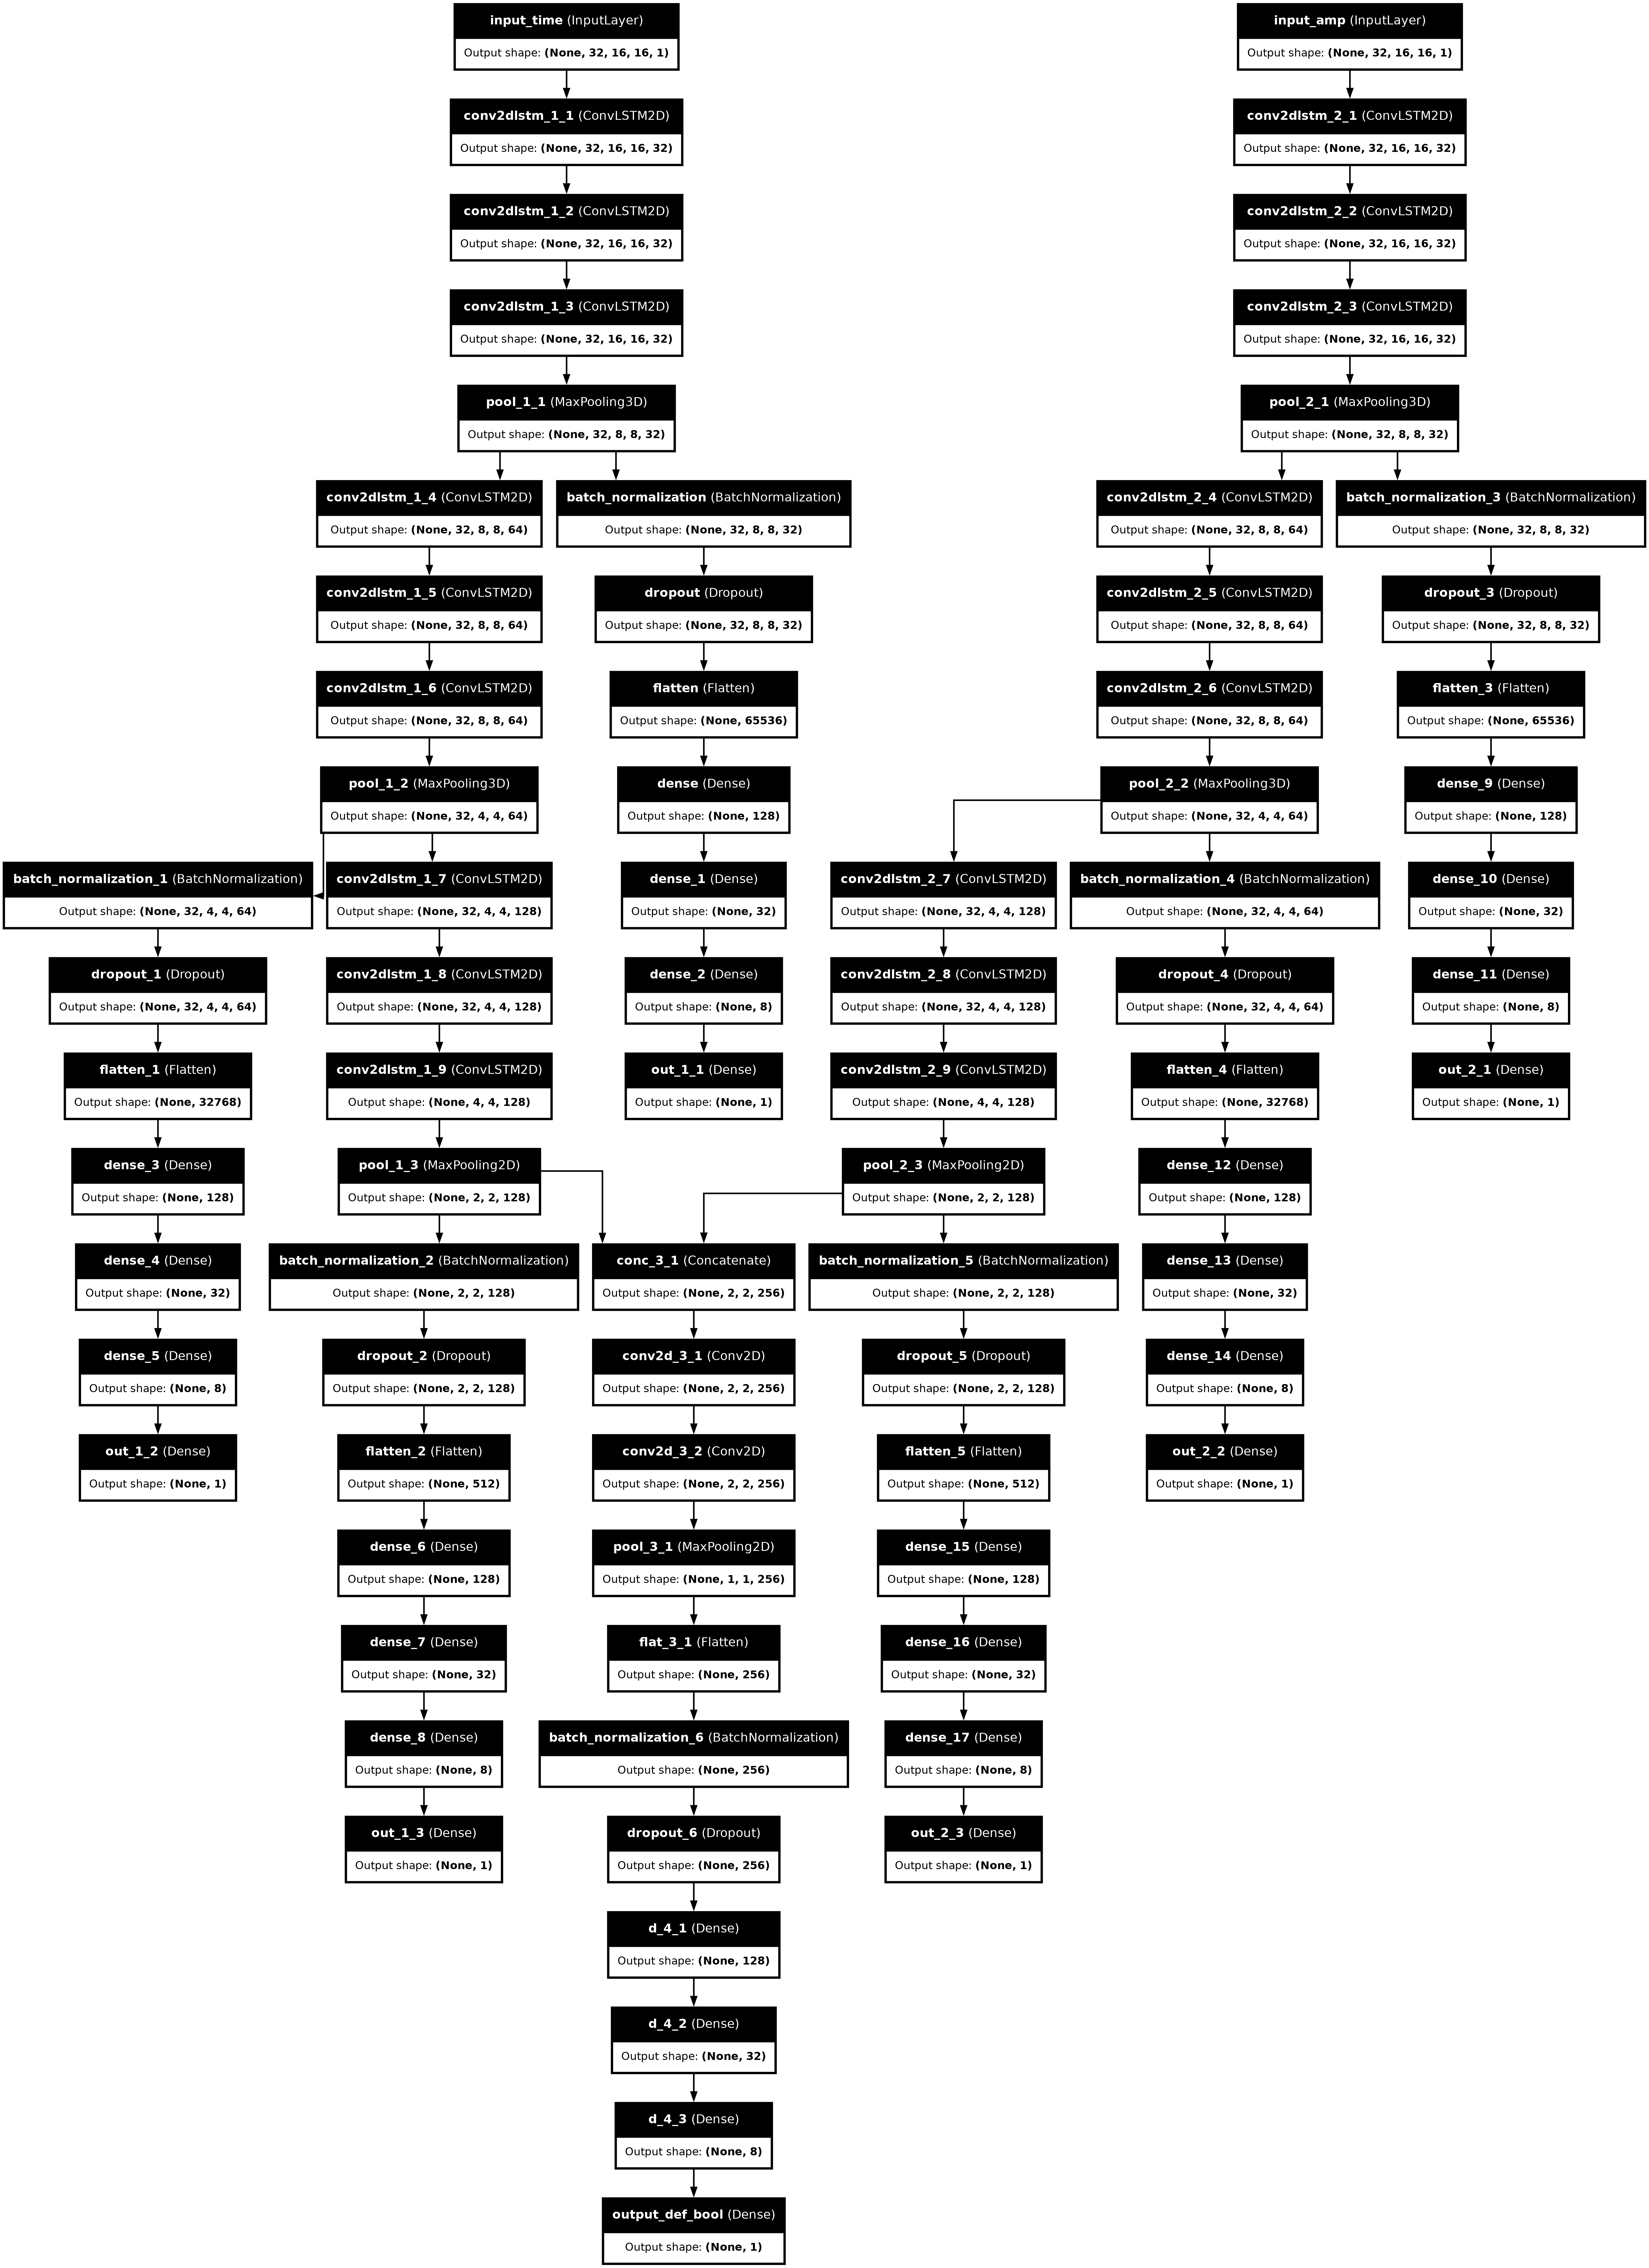

In [9]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
)

In [10]:
# Создание и настройка колбэков

callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

callback_list.append(keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights,
            mode=ES_mode
            ))

callback_list.append(keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            ))

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [ ]:
history = model.fit([train_x_time, train_x_amp], [train_y_binary,train_y_binary,train_y_binary,train_y_binary,train_y_binary,train_y_binary,train_y_binary],
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    shuffle = True,
                    validation_data = ([val_x_time, val_x_amp], [val_y_binary,val_y_binary,val_y_binary,val_y_binary,val_y_binary,val_y_binary,val_y_binary]), 
                    callbacks = FIT_callback_list)

I0000 00:00:1712633229.307889   25898 service.cc:145] XLA service 0x5ce2802a6f70 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712633229.307909   25898 service.cc:153]   StreamExecutor device (0): Radeon RX 7900 XT, AMDGPU ISA version: gfx1100
I0000 00:00:1712633244.060856   25898 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


728/728 ━━━━━━━━━━━━━━━━━━━━ 312s 396ms/step - loss: 4.2655 - out_1_1_MSE: 0.2024 - out_1_2_MSE: 0.2104 - out_1_3_MSE: 0.2051 - out_2_1_MSE: 0.1966 - out_2_2_MSE: 0.2016 - out_2_3_MSE: 0.2009 - output_def_bool_AUC: 0.5025 - output_def_bool_BinaryAccuracy: 0.7198 - output_def_bool_FalseNegatives: 379.8861 - output_def_bool_FalsePositives: 12.9150 - output_def_bool_MSE: 0.2448 - output_def_bool_Precision: 0.3109 - output_def_bool_Recall: 0.0324 - output_def_bool_TrueNegatives: 1061.3347 - output_def_bool_TruePositives: 5.8587 - val_loss: 3.7873 - val_out_1_1_MSE: 0.1652 - val_out_1_2_MSE: 0.1552 - val_out_1_3_MSE: 0.1602 - val_out_2_1_MSE: 0.2192 - val_out_2_2_MSE: 0.1583 - val_out_2_3_MSE: 0.1520 - val_output_def_bool_AUC: 0.5000 - val_output_def_bool_BinaryAccuracy: 0.8512 - val_output_def_bool_FalseNegatives: 400.0000 - val_output_def_bool_FalsePositives: 0.0000e+00 - val_output_def_bool_MSE: 0.2262 - val_output_def_bool_Precision: 0.0000e+00 - val_output_def_bool_Recall: 0.0000e+00 -

In [ ]:
FONT_SIZE = 15
fig, axes = plt.subplots()

fig.set_figwidth(22)
fig.set_figheight(12)

for key in [k for k in history.history.keys() if not k.startswith('val') and k.endswith('MSE')]:
    axes.plot(history.history[key], label=key,  linewidth=1.5, color='blue')
    axes.plot(history.history[f'val_{key}'], linestyle = '--', label=f'val_{key}',  linewidth=3, color='red')

axes.set_xlabel('Epoch number', fontsize=FONT_SIZE)
axes.set_ylabel(f'MSE value', fontsize=FONT_SIZE)
axes.set_title(f"Learning process plot", fontsize=FONT_SIZE, pad=15)
axes.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
axes.minorticks_on()
axes.grid(which='major', linewidth=2)
axes.grid(which='minor', color = 'gray', linestyle = ':')
axes.legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')
plt.show()

In [ ]:
FONT_SIZE = 15
fig, axes = plt.subplots()

fig.set_figwidth(22)
fig.set_figheight(12)

axes.plot(history.history['loss'], label='loss',  linewidth=1.5, color='blue')
axes.plot(history.history['val_loss'], linestyle = '--', label='val_loss',  linewidth=3, color='red')

axes.set_xlabel('Epoch number', fontsize=FONT_SIZE)
axes.set_ylabel(f'MSE value', fontsize=FONT_SIZE)
axes.set_title(f"Learning process plot", fontsize=FONT_SIZE, pad=15)
axes.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
axes.minorticks_on()
axes.grid(which='major', linewidth=2)
axes.grid(which='minor', color = 'gray', linestyle = ':')
axes.legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')
plt.show()

In [ ]:
FONT_SIZE = 15
for key1,key2 in zip(['output_def_bool_BinaryAccuracy','output_def_bool_Precision','output_def_bool_MeanSquaredError','output_def_bool_TruePositives','output_def_bool_TrueNegatives'],
                     ['output_def_bool_MSE','output_def_bool_Recall','output_def_bool_AUC','output_def_bool_FalseNegatives','output_def_bool_FalsePositives']):
    fig, axes = plt.subplots(1,2)

    fig.set_figwidth(22)
    fig.set_figheight(8)
    
    axes[0].plot(history.history[key1], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[0].plot(history.history[f'val_{key1}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[0].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[0].set_ylabel(f'{key1} value', fontsize=FONT_SIZE)
    axes[0].set_title(f"Learning process {key1} plot", fontsize=FONT_SIZE, pad=15)
    axes[0].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[0].minorticks_on()
    axes[0].grid(which='major', linewidth=2)
    axes[0].grid(which='minor', color = 'gray', linestyle = ':')
    axes[0].legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')

    axes[1].plot(history.history[key2], 
             label='Train dataset',  linewidth=1.5, color='blue')
    axes[1].plot(history.history[f'val_{key2}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    axes[1].set_xlabel('Epoch number', fontsize=FONT_SIZE)
    axes[1].set_ylabel(f'{key2} value', fontsize=FONT_SIZE)
    axes[1].set_title(f"Learning process {key2} plot", fontsize=FONT_SIZE, pad=15)
    axes[1].tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    axes[1].minorticks_on()
    axes[1].grid(which='major', linewidth=2)
    axes[1].grid(which='minor', color = 'gray', linestyle = ':')
    axes[1].legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')

    plt.show()

In [ ]:
'''FONT_SIZE = 15
for key in [k for k in history.history.keys() if not k.startswith('val')]:
    fig, ax = plt.subplots()

    fig.set_figwidth(12)
    fig.set_figheight(8)
    
    plt.plot(history.history[key], 
             label='Train dataset',  linewidth=1.5, color='blue')
    plt.plot(history.history[f'val_{key}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    
    ax.set_xlabel('Epoch number', fontsize=FONT_SIZE)
    ax.set_ylabel(f'{key} value', fontsize=FONT_SIZE)
    ax.set_title(f"Learning process {key} plot", fontsize=FONT_SIZE, pad=15)
    
    ax.patch.set_alpha(0)
    
    #  Устанавливаем форматирование делений:
    ax.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    
    # Вывод и настройка сетки
    ax.minorticks_on()
    ax.grid(which='major', linewidth=2)
    ax.grid(which='minor', color = 'gray', linestyle = ':')
    
    ax.legend(fontsize = FONT_SIZE, facecolor = "white", loc = 'upper right')
    
    plt.show()'''

In [ ]:
# сохранение модели в файл
#model.save(f"networks/CNN/id=v10n03_in({CROP_SIZE}x{CROP_SIZE}+{CROP_SIZE}x{CROP_SIZE})_out(1)_train=0dot0_test=0dot0.keras")

#### 